<a href="https://colab.research.google.com/github/RachelRamirez/misclassification_matrix/blob/main/PreExperiment_PA_Shfl_40D_100_Lambda2_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PreExperiment PA Shfl 40D Lambda1=100 Lambda2 FineTuning

This notebook is called this because I believe my weights aren't properly responding to the 'new' misclassification cost matrix, after receiving it.  Therefore, I probably need to use fine-tuninign principles to initialize the weights of the neural network, similar to the weights it would have if it was trained with Lambda-1 for 5 epochs, load those with a new initialized network, then send it the updated Lambda-value at 'epoch 5' which is really epoch 1 for the 'new network' and see what happens to the loss values.


## Reduced  capacity neural network with two layers of 40 connections

 

#### Check timezone if incorrect restart

In [2]:
# How to change the local time in Google Colab
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/US/Eastern /etc/localtime
!date

#If this doesn't show the local time correctly, then you need to restart.
import time
time.localtime(time.time())

Tue 25 Apr 2023 03:07:26 PM EDT


time.struct_time(tm_year=2023, tm_mon=4, tm_mday=25, tm_hour=19, tm_min=7, tm_sec=26, tm_wday=1, tm_yday=115, tm_isdst=0)

### Reproducible Seeds

In [3]:
#For Reproducibility
import numpy as np
# np.random.seed(1337)  # for reproducibility

import tensorflow as tf
# tf.random.set_seed(33)

import random as python_random
# python_random.seed(4)

# https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed
seed = 342
tf.keras.utils.set_random_seed(seed) #Possibly use next iteration if the above doesn't work   #This makes everything VERY DETERMINISTIC


# Running more than once causes variation.  try adding this:
# Set seed value
seed_value = 56
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

print("TF version: " , tf.__version__ )
print("Keras version: " , tf.keras.__version__ )


 

TF version:  2.12.0
Keras version:  2.12.0


### Import rest of Library

In [4]:

# from https://github.com/keras-team/keras/issues/2115#issuecomment-204060456
# witha correction on the weighted function in the middle 

'''Train a simple deep NN on the MNIST dataset.
Get to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

# from __future__ import print_function  #do i still need this?
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K
from itertools import product
import functools
from functools import partial
from time import ctime
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix
from  sklearn.utils import shuffle

## MORE REPEATABILITY STUFF NEEDED - If theres a way to update this to V2 of Tensorflow great, otherwise I had to use TF 1.0 code
# 5. Configure a new global `tensorflow` session (https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds)
# from keras import backend as K


#I believe thecode below is to help things be repeatable each time different sections in my google colab notebook execute
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
!date


Tue 25 Apr 2023 03:07:39 PM EDT


In [ ]:
# # After executing the cell above, Drive
# # files will be present in "/content/drive/My Drive".
# # !ls "/content/drive/My Drive/Con3"
# path = "/content/drive/MyDrive/Con3/"
 

# import pickle 
# variable_to_be_deleted = np.array((1,10))
# file_name = "delete_later.pkl"
# with open(path + file_name, 'wb') as handle:
      
#     # A new file will be created
#     pickle.dump(variable_to_be_deleted, handle,  protocol=pickle.HIGHEST_PROTOCOL)

# print(file_name, " was saved to Google MyDrive ")

# import os
# try:
#     os.remove(path+file_name)
#     print(file_name, " was deleted from Google MyDrive ")
# except:
#     print("Error while deleting file : ", path+file_name)
# del(file_name, variable_to_be_deleted)


### Define batch, and format data

In [6]:
batch_size = 256 

# I originally had it very  high batch size to reduce the variation in the data each batch and hope 
# it makes the model training more nearly identical which it did, then i bring it back down to something reasonable to get better results training the NN

nb_classes = 10

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
# print(X_train.shape[0], 'train samples')
# print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#Create a Validation Set
X_val = X_test[:7500]   #take the first 7500 for validation
Y_val = Y_test[:7500]   #Take the first 7500 for validation
y_val = y_test[:7500]

X_test = X_test[7500:]  #Keep the last 2500 for test/holdout
Y_test = Y_test[7500:]  #Keep the last 2500 for test/holdout
y_test = y_test[7500:]

print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

#Are the sets relatively balanced? Yes each category is between 8% and 11% per category
print('Train', Y_train.sum(axis=0)/X_train.shape[0])
print('Train # of 9s', Y_train.sum(axis=0)[9])
print('Train # of 4s', Y_train.sum(axis=0)[4])

print('Val', Y_val.sum(axis=0)/X_val.shape[0])
print('Val # of 9s', Y_val.sum(axis=0)[9])
print('Val # of 4s', Y_val.sum(axis=0)[4])

print('Test', Y_test.sum(axis=0)/X_test.shape[0])
print('Test  # of 9s', Y_test.sum(axis=0)[9])
print('Test  # of 4s', Y_test.sum(axis=0)[4])


!date


11490434/11490434 [==============================] - 1s 0us/step
60000 train samples
7500 validation samples
2500 test samples
Train [0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751666 0.09915   ]
Train # of 9s 5949.0
Train # of 4s 5842.0
Val [0.09586667 0.1132     0.10453334 0.10066666 0.09986667 0.09013333
 0.09413333 0.1016     0.09746667 0.10253333]
Val # of 9s 769.0
Val # of 4s 749.0
Test [0.1044 0.1144 0.0992 0.102  0.0932 0.0864 0.1008 0.1064 0.0972 0.096 ]
Test  # of 9s 240.0
Test  # of 4s 233.0
Tue 25 Apr 2023 03:07:46 PM EDT



### Weighted Categorical Cross Entropy Class

In [7]:
#@title
class WeightedCategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):

  def __init__(self, cost_mat, name='weighted_categorical_crossentropy', **kwargs):

    cost_mat = np.array(cost_mat)   
    ## when loading from config, self.cost_mat returns as a list, rather than an numpy array. 
    ## Adding the above line fixes this issue, enabling .ndim to call sucessfully. 
    ## However, this is probably not the best implementation
    assert(cost_mat.ndim == 2)
    assert(cost_mat.shape[0] == cost_mat.shape[1])
    super().__init__(name=name, **kwargs)
    self.cost_mat = K.cast_to_floatx(cost_mat)

  def __call__(self, y_true, y_pred, sample_weight=None):
    assert sample_weight is None, "should only be derived from the cost matrix"  
    return super().__call__(
        y_true=y_true, 
        y_pred=y_pred, 
        sample_weight=get_sample_weights(y_true, y_pred, self.cost_mat),
    )


  def get_config(self):
    config = super().get_config().copy()
    # Calling .update on the line above, during assignment, causes an error with config becoming None-type.
    config.update({'cost_mat': (self.cost_mat)})
    return config

  @classmethod
  def from_config(cls, config):
    # something goes wrong here and changes self.cost_mat to a list variable.
    # See above for temporary fix
    return cls(**config)

def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)

    y_pred.shape.assert_has_rank(2)
    assert(y_pred.shape[1] == num_classes)
    y_pred.shape.assert_is_compatible_with(y_true.shape)

    y_pred = K.one_hot(K.argmax(y_pred), num_classes)

    y_true_nk1 = K.expand_dims(y_true, 2)
    y_pred_n1k = K.expand_dims(y_pred, 1)
    cost_m_1kk = K.expand_dims(cost_m, 0)

    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = K.sum(sample_weights_nkk, axis=[1, 2])

    return sample_weights_n


# Register the loss in the Keras namespace to enable loading of the custom object.
tf.keras.losses.WeightedCategoricalCrossentropy = WeightedCategoricalCrossentropy
 

### Plot Model History

In [8]:
#@title
def plot_model_history(model_history, nb_epoch, cm3): 
  # Parameters
  # ----------
  # model_history : keras.callbacks.History
  #     The history object returned by the fit() method of the model.
  # cm3 : 10x10 dataframe 
  #      10x10 dataframe of confusion matrix from predicted X_val categories
  # nb_epoch = restored_weights : int
  #     The epoch at which the weights were restored.
  # tot_epochs : int
  #     Calculated Total number of epochs for which the model was trained.
  
   
  tot_epochs = max(model_history.epoch)+1  #if the total epochs ran is 28, it'll show up as 27 in the epoch object so we must add 1
  print("Total Epochs: ", tot_epochs)

  #if tot_epochs is the total number of epochs ran then early stop did not happen, and we need not minus patience
  if tot_epochs == nb_epoch:
    restored_weights = tot_epochs
  else:
    restored_weights  = tot_epochs-patience   #when using restore-best-weights and patience, it'll restore the best weights back
  print("Restored weights at ", restored_weights, "Patience used: ", patience)

  fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
  fig, ax = plt.subplots(1,3)
  ax[0].plot(range(1,tot_epochs+1), model_history.history['categorical_accuracy'], color='blue',             label='Training')
  ax[0].plot(range(1,tot_epochs+1), model_history.history['val_categorical_accuracy'] , color='orange',             label='Validation')
  ax[0].scatter((restored_weights), model_history.history['val_categorical_accuracy'][restored_weights-1] , color='orange')
  ax[0].scatter(restored_weights, model_history.history['categorical_accuracy'][restored_weights-1], color='blue')
  ax[0].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_categorical_accuracy'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center', color='black')
  ax[0].legend()
  ax[0].set_title('Training and Validation Accuracy')

  ax[1].plot(range(1,tot_epochs+1), model_history.history['loss'], color= 'blue', label='Training')
  ax[1].plot(range(1,tot_epochs+1), model_history.history['val_loss'], color='orange', label='Validation')
  ax[1].scatter(restored_weights, model_history.history['loss'][restored_weights-1], color='blue')
  ax[1].scatter((restored_weights), model_history.history['val_loss'][restored_weights-1] , color='orange')
  ax[1].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_loss'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center')
  ax[1].legend()
  ax[1].set_title('Training and Validation Loss')


  cm3_wodiag = cm3*(np.ones((10,10)) - np.eye(10))

  ax[2] = sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r) # font size
  ax[2].set_xlabel('Predicted Class')
  ax[2].set_ylabel('True Class')
  ax[2].set_title('# of misclassifications of 9 as 4 is '+str(cm3[4][9]))
  cbar = ax[2].collections[0].colorbar
  cbar.remove() # Just takes up valuable room and is worthless


  plt.gcf().set_size_inches(15, 5)  # this works 
  # plt.gcf().suptitle(f"Lambda Value {lambda_val} for {nb_epoch} Epochs and Patience {patience} " )

### Train Model with WeightedCategoricalCross Entropy Function 

In [9]:
#@title
def create_model(): #Removed cost-matrix which is called up in the Compile Function and passed to the weighted-loss function
  model = Sequential()
  model.add(Dense(40, input_shape=(784,), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(40, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10,kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)))
  model.add(Activation('softmax'))
  return model  #I removed Compile



In [10]:
#@title
def log_confusion_matrix( epoch, logs):
  # Use the model to predict the values from the validation dataset.
  y_prediction = model.predict(X_val, verbose=0)     #I call it y_prediction3 because I just want to make sure this is  updated within and not interfering with the other prediction below
  y_prediction  = np.argmax(y_prediction, axis=1)

  #Create confusion matrix 
  cm = confusion_matrix(y_val, y_prediction)
  cm_array = np.asarray(cm)  #Indiv CM as array for storing
  logs['9T_4P'] = cm[9,4]
  logs['4T_9P'] = cm[4,9]
  logs['cm_per_epoch'] = cm_array.reshape((1,100))


In [11]:
#@title
def return_cm(model):
  y_prediction = model.predict(X_val, verbose=0)
  y_prediction  = np.argmax(y_prediction, axis=1)
  # Y_prediction = np_utils.to_categorical(y_prediction, nb_classes)

  cm3 = confusion_matrix(y_val, y_prediction)
  cm3 = pd.DataFrame(cm3, range(10),range(10))
  return cm3

  # # plt.figure(figsize = (4,4))
  # # cm3
  # sns.heatmap(cm3, annot=True, annot_kws={"size": 7},  fmt='g') # font size
  # plt.show()
  # # cm_using_weighted_new = cm3
 

In [12]:
#@title
# #As of 4/18 I am changing this code to save weights initially after five epochs using lambdavalue=1 initially

rms = RMSprop()  #https://keras.io/api/optimizers/rmsprop/

patience = 0


# SET THE IITIAL LAMBDA VALUE! 
cost_matrix = np.ones((10,10))
lambda_val = 100  

Truth=9
Predicted=4
cost_matrix[Truth, Predicted] = lambda_val


# # Define the per-epoch callback.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix, )
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)


model = create_model()

# save the model weights
# model.save_weights('initial_0epochs.h5')
model.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=rms,  metrics='categorical_accuracy',)

model_history = model.fit(X_train, Y_train,  batch_size=batch_size, epochs=5, verbose=2,
        validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True, callbacks = [ cm_callback])

# save the model weights
model.save_weights('initial_5epochs.h5')

# load the model weights
model.load_weights('initial_5epochs.h5')
 

Epoch 1/5
235/235 - 5s - loss: 1.1485 - categorical_accuracy: 0.6843 - val_loss: 0.4925 - val_categorical_accuracy: 0.8595 - 9T_4P: 4.0000 - 4T_9P: 338.0000 - cm_per_epoch: 75.0000 - 5s/epoch - 22ms/step
Epoch 2/5
235/235 - 1s - loss: 0.5977 - categorical_accuracy: 0.8405 - val_loss: 0.3505 - val_categorical_accuracy: 0.8971 - 9T_4P: 2.0000 - 4T_9P: 207.0000 - cm_per_epoch: 75.0000 - 1s/epoch - 5ms/step
Epoch 3/5
235/235 - 1s - loss: 0.5006 - categorical_accuracy: 0.8766 - val_loss: 0.3354 - val_categorical_accuracy: 0.9157 - 9T_4P: 5.0000 - 4T_9P: 140.0000 - cm_per_epoch: 75.0000 - 1s/epoch - 5ms/step
Epoch 4/5
235/235 - 1s - loss: 0.4466 - categorical_accuracy: 0.8935 - val_loss: 0.2650 - val_categorical_accuracy: 0.9093 - 9T_4P: 0.0000e+00 - 4T_9P: 250.0000 - cm_per_epoch: 75.0000 - 1s/epoch - 5ms/step
Epoch 5/5
235/235 - 1s - loss: 0.3881 - categorical_accuracy: 0.9020 - val_loss: 0.3098 - val_categorical_accuracy: 0.9324 - 9T_4P: 6.0000 - 4T_9P: 96.0000 - cm_per_epoch: 75.0000 - 1

In [14]:
#@title
def plot_model_history_all(model_history, nb_epoch=None, cm3=None): 
  # Parameters
  # ----------
  # tot_epochs : int
  #     Total number of epochs for which the model was trained.
  # model_history : keras.callbacks.History
  #     The history object returned by the fit() method of the model.
  # cm3 : 10x10 dataframe 
  #      10x10 dataframe of confusion matrix from predicted X_val categories
  # restored_weights : int
  #     The epoch at which the weights were restored.

  

  tot_epochs = max(model_history.epoch)+1  #if the total epochs ran is 28, it'll show up as 27 in the epoch object so we must add 1
  # print("Total Epochs: ", tot_epochs)

  #if tot_epochs is the total number of epochs ran then early stop did not happen, and we need not minus patience
  if tot_epochs == nb_epoch:
    restored_weights = tot_epochs
  else:
    restored_weights  = tot_epochs-patience   #when using restore-best-weights and patience, it'll restore the best weights back
  # print("Restored weights at ", restored_weights, "Patience used: ", patience)

  ax[0].plot(range(1,tot_epochs+1), model_history.history['categorical_accuracy'], color='blue',           )
  ax[0].plot(range(1,tot_epochs+1), model_history.history['val_categorical_accuracy'] , color='orange',    )
  ax[0].scatter((restored_weights), model_history.history['val_categorical_accuracy'][restored_weights-1] , color='orange')
  ax[0].scatter(restored_weights, model_history.history['categorical_accuracy'][restored_weights-1], color='blue')
  ax[0].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_categorical_accuracy'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center', color='black')
  # ax[0].legend()
  ax[0].set_title('Training (Blue) and Validation (Orange) Accuracy', fontsize='8')

  ax[1].plot(range(1,tot_epochs+1), model_history.history['loss'], color= 'blue',  )
  ax[1].plot(range(1,tot_epochs+1), model_history.history['val_loss'], color='orange',  )
  ax[1].scatter(restored_weights, model_history.history['loss'][restored_weights-1], color='blue')
  ax[1].scatter((restored_weights), model_history.history['val_loss'][restored_weights-1] , color='orange')
  ax[1].annotate(text=str(restored_weights),  xy=(restored_weights, model_history.history['val_loss'][restored_weights-1]),
                  textcoords="offset points", xytext=(0,10), ha='center')
  # ax[1].legend()
  ax[1].set_title('Training (Blue) and Validation (Orange) Loss' , fontsize='8')


  plt.gcf().set_size_inches(10, 5)  # this works 
  # plt.gcf().suptitle(f"Lambda Value {lambda_val} for {nb_epoch} Epochs and Patience {patience} " )

<Figure size 2000x1000 with 0 Axes>

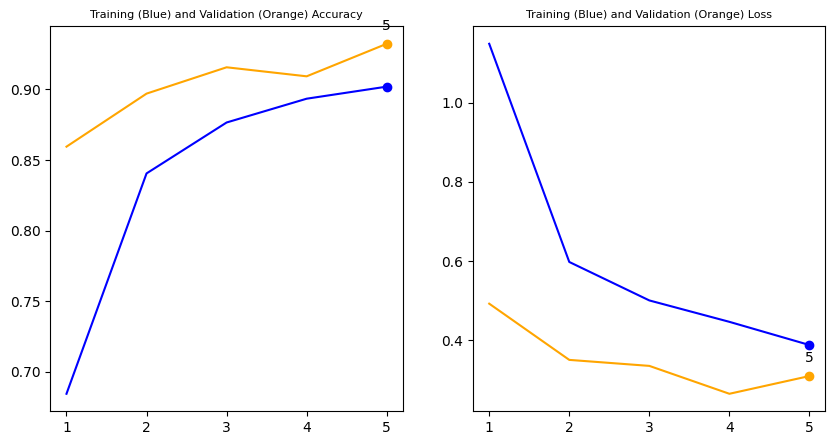

In [15]:
fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
fig, ax = plt.subplots(1,2)
plot_model_history_all(model_history)
plt.show()

The code below to generate variations of the model training / validation results after training with a cost matrix 30 times did not produce any variability.   Therefore I want to shuffle the training/validation deck randomly between training sessions to see if that helps introduce some randomness.  

In [18]:
# #@title

# ## -----------------------------------------------------------------------------------------------------
# ## Now we need to load the weights of the model, and continue training with a different cost matrix
# ## ------------------------------------------------------------------------------------------------------
# # load the model weights
# # model.load_weights('initial_5epochs.h5')
# rms = RMSprop()  #https://keras.io/api/optimizers/rmsprop/


# cost_matrix = np.ones((10,10))

# model_history_all = []
# cm_all            = []

# cost_list = [10, 100, 1000, 1] # Each one takes about 2 minutes 5*4*2=40 minutes for 5 costs/4 reps -- actually all took 40 reps took almost  1.5 hours

# for k in cost_list:
#   for i in range(10):


#     cost_matrix[9,4] = k
#     model = create_model()
#     model.load_weights('initial_5epochs.h5')

#     #I may need to re-initiate the optimizer to have a smaller learning rate
#     model.compile(loss=WeightedCategoricalCrossentropy(cost_matrix), optimizer=rms,  metrics='categorical_accuracy',)
    
#     nb_epoch = 50
#     patience = 20

#     es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights = True)

#     X_train_shuffled = shuffle(X_train, random_state=42+i)
#     Y_train_shuffled = shuffle(Y_train, random_state=42+i)


#     history = model.fit(X_train_shuffled, Y_train_shuffled,          batch_size=batch_size, epochs=nb_epoch, verbose=1,
#             validation_data=(X_val, Y_val), shuffle=True, use_multiprocessing=True, callbacks = [es_callback, cm_callback])

#     cm3 = return_cm(model)

#     model_history_all.append(history)
#     cm_all.append(cm3)
#     ## Now I need to plot all of the "model_history_all"
  
#   # # print(model_history_all)
#   # fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
#   # fig, ax = plt.subplots(1,3)
#   # for item in (model_history_all):
#   #     # print(item)
#   #   plot_model_history_all(item)



#   # print(model_history_all) #18 items into _ is taking 1 hours and 3 minutes!  perhaps im not usng the right settings - i have no-accelerator on google colab

Epoch 1/50
235/235 [==============================] - 2s 6ms/step - loss: 0.2928 - categorical_accuracy: 0.9189 - val_loss: 0.2033 - val_categorical_accuracy: 0.9435 - 9T_4P: 12.0000 - 4T_9P: 35.0000 - cm_per_epoch: 75.0000
Epoch 2/50
235/235 [==============================] - 1s 5ms/step - loss: 0.2637 - categorical_accuracy: 0.9275 - val_loss: 0.2039 - val_categorical_accuracy: 0.9465 - 9T_4P: 12.0000 - 4T_9P: 24.0000 - cm_per_epoch: 75.0000
Epoch 3/50
235/235 [==============================] - 1s 5ms/step - loss: 0.2523 - categorical_accuracy: 0.9306 - val_loss: 0.1862 - val_categorical_accuracy: 0.9511 - 9T_4P: 9.0000 - 4T_9P: 22.0000 - cm_per_epoch: 75.0000
Epoch 4/50
235/235 [==============================] - 1s 5ms/step - loss: 0.2343 - categorical_accuracy: 0.9346 - val_loss: 0.1857 - val_categorical_accuracy: 0.9519 - 9T_4P: 11.0000 - 4T_9P: 19.0000 - cm_per_epoch: 75.0000
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.2298 - categorical_accuracy: 

In [32]:
# # Download the history
# from google.colab import files

# for item in model_history_all:
#   # item.history
#   del item.model


# import pickle

# # create a variable
# #model_history_all #50 items
# #cm_all #50 items

# # save the variable to a pickle file
# with open('initial_100_secondphase_lambda_history.pkl', 'wb') as f:
#     pickle.dump(model_history_all, f)

# files.download('initial_100_secondphase_lambda_history.pkl')

# with open('initial_100_secondphase_lambda_cm.pkl', 'wb') as f:
#     pickle.dump(cm_all, f)

# files.download('initial_100_secondphase_lambda_cm.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 2000x1000 with 0 Axes>

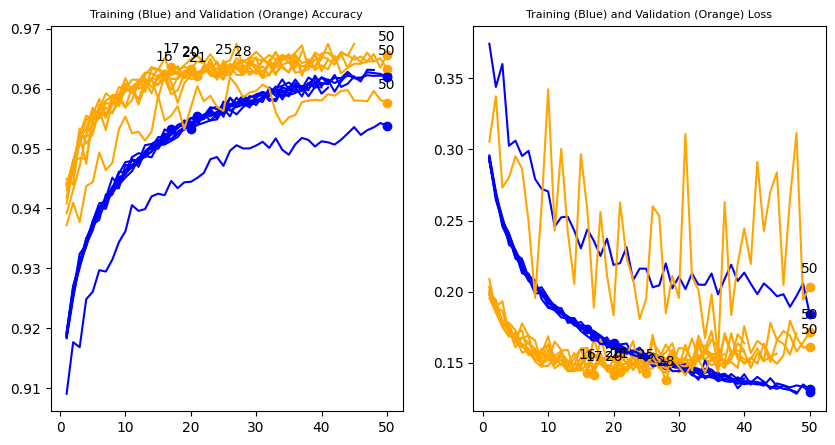

<Figure size 2000x1000 with 0 Axes>

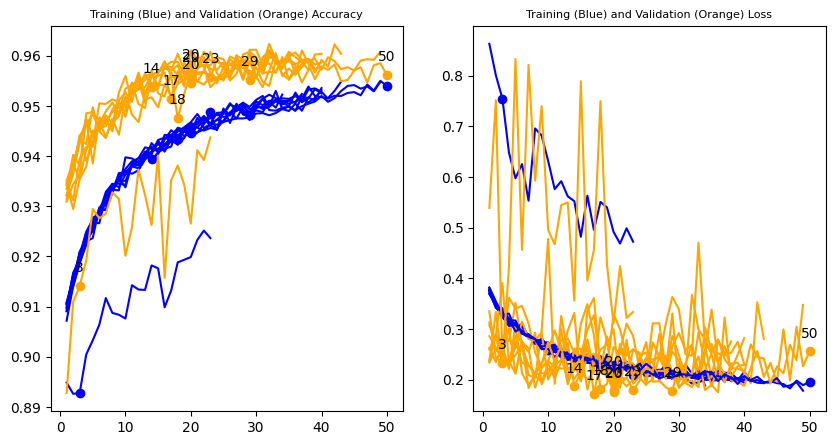

<Figure size 2000x1000 with 0 Axes>

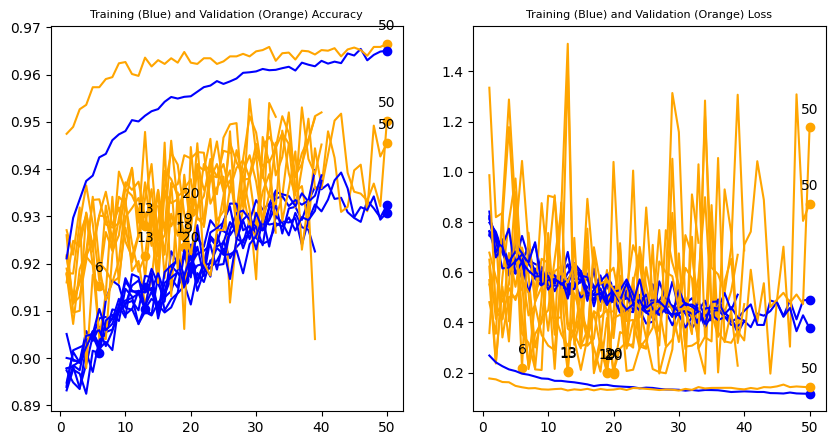

<Figure size 2000x1000 with 0 Axes>

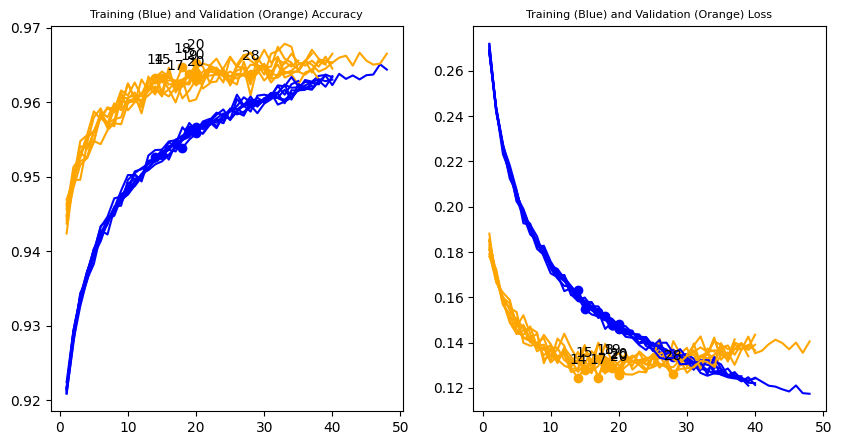

In [25]:
#@title
for r in range(0,40,10):
  # print(r)
  ## Now I need to plot all of the "model_history_all"
  fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
  fig, ax = plt.subplots(1,2)

  for item, cm in zip(model_history_all[0+r+1:r+10+1], cm_all):
      # print(item)
    plot_model_history_all(item, nb_epoch, cm)
    # print(0+r,' to ', r+4+1)  #Correct


Load Model History Variables from Pickle Files - must have weighted-categorical-accuracy defined

In [16]:
#Upload and save the history to variable 
import pickle

# #load the pickle file
with open('initial_100_secondphase_lambda_history.pkl', 'rb') as handle:
    model_history_all = pickle.load(handle)

# import keras
# keras.models.load_model('initial_100_secondphase_lambda_history.pkl')
#use the loaded variable
print(model_history_all)

#load the pickle file
with open('initial_100_secondphase_lambda_cm.pkl', 'rb') as handle:
    cm_all = pickle.load(handle)

#use the loaded variable
print(cm_all)

 

[<keras.callbacks.History object at 0x7fed8c205d00>, <keras.callbacks.History object at 0x7fed8c2194f0>, <keras.callbacks.History object at 0x7fed8c218820>, <keras.callbacks.History object at 0x7fed8c2237f0>, <keras.callbacks.History object at 0x7fed8c227760>, <keras.callbacks.History object at 0x7fed8c22b550>, <keras.callbacks.History object at 0x7fed8c205b50>, <keras.callbacks.History object at 0x7fed8c230e20>, <keras.callbacks.History object at 0x7fed8c1c40d0>, <keras.callbacks.History object at 0x7fed8c1c4ee0>, <keras.callbacks.History object at 0x7fed8c1d6250>, <keras.callbacks.History object at 0x7fed8c1e0580>, <keras.callbacks.History object at 0x7fed8c1e94f0>, <keras.callbacks.History object at 0x7fed8c1f2580>, <keras.callbacks.History object at 0x7fed8c1fa4f0>, <keras.callbacks.History object at 0x7fed8c1823a0>, <keras.callbacks.History object at 0x7fed8c18c0d0>, <keras.callbacks.History object at 0x7fed8c18cee0>, <keras.callbacks.History object at 0x7fed8c19b250>, <keras.call

In [17]:
#@title
#  show a dataframe in python filled in with a forloop

# import pandas as pd 

# data = {'Name':['John', 'Bob', 'Sue', 'Alice'], 
#         'Age':[20,30,25,18], 
#         'Country':['USA','UK','Canada','Australia']} 

# df = pd.DataFrame(data) 

# for index, row in df.iterrows(): 
#     print(row['Name'], row['Age'], row['Country']) 

# # Output 
# John 20 USA 
# Bob 30 UK 
# Sue 25 Canada 
# Alice 18 Australia


In [18]:
#@title
import pandas as pd

# Create an empty dataframe
df = pd.DataFrame()

# Create a list of data
data = [1, 2, 3, 4, 5]

# Use a for loop to fill the dataframe
for x in data:
    df = pd.concat([df, pd.DataFrame({'Number':[x], 'Square':[x**2]})], ignore_index=True)

# Show the dataframe
print(df)

   Number  Square
0       1       1
1       2       4
2       3       9
3       4      16
4       5      25


In [19]:
#I want to break out the model_history and cm_history into a dataframe to be referenced by Cost and Rep
import pandas as pd
df = pd.DataFrame()
count=1

cost_list = [10, 100, 1000, 1] # Each one takes about 2 minutes 5*4*2=40 minutes for 5 costs/4 reps -- actually all took 40 reps took almost  1.5 hours



for k in cost_list:
  for i in range(10):
    print("k: ", k, "i: ", i)
    df = pd.concat([df, pd.DataFrame({"cost": [k], "rep": [i],
                                      "model_history": [model_history_all[count-1]],
                                      "cm": [cm_all[count-1]]})] , ignore_index=True )
    count+=1    


df.to_csv('dataframe.csv',index=False)



k:  10 i:  0
k:  10 i:  1
k:  10 i:  2
k:  10 i:  3
k:  10 i:  4
k:  10 i:  5
k:  10 i:  6
k:  10 i:  7
k:  10 i:  8
k:  10 i:  9
k:  100 i:  0
k:  100 i:  1
k:  100 i:  2
k:  100 i:  3
k:  100 i:  4
k:  100 i:  5
k:  100 i:  6
k:  100 i:  7
k:  100 i:  8
k:  100 i:  9
k:  1000 i:  0
k:  1000 i:  1
k:  1000 i:  2
k:  1000 i:  3
k:  1000 i:  4
k:  1000 i:  5
k:  1000 i:  6
k:  1000 i:  7
k:  1000 i:  8
k:  1000 i:  9
k:  1 i:  0
k:  1 i:  1
k:  1 i:  2
k:  1 i:  3
k:  1 i:  4
k:  1 i:  5
k:  1 i:  6
k:  1 i:  7
k:  1 i:  8
k:  1 i:  9


```
for group in df.groupby("cost"): 
  fig = plt.figure(figsize=(20, 10))  
  fig, ax = plt.subplots(1,2) 
  ax[0].scatter(group[1]["cost"], group[1]["quantity"]) 
  ax[0].set_title("cost vs. quantity") 
  ax[1].scatter(group[1]["cost"], group[1]["revenue"]) 
  ax[1].set_title("cost vs. revenue")
  plt.show()

```


Group of Lambda-Value: 1


<Figure size 2000x1000 with 0 Axes>

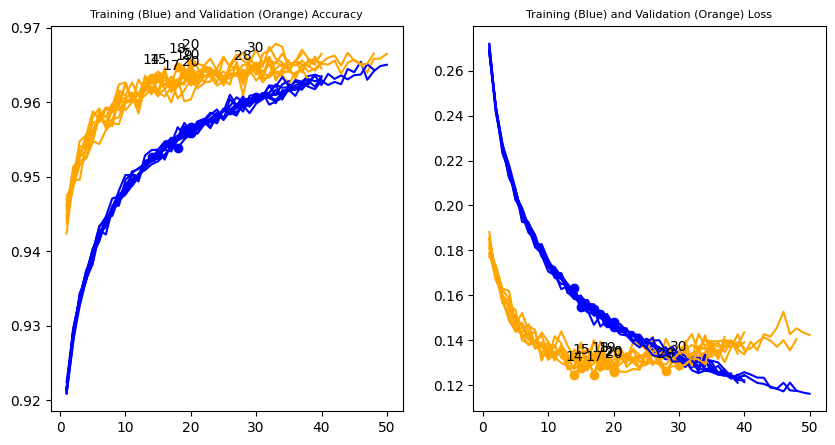

Group of Lambda-Value: 10


<Figure size 2000x1000 with 0 Axes>

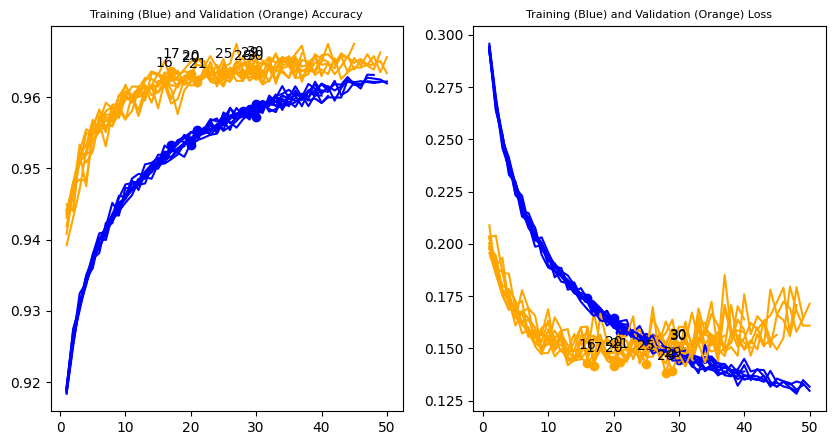

Group of Lambda-Value: 100


<Figure size 2000x1000 with 0 Axes>

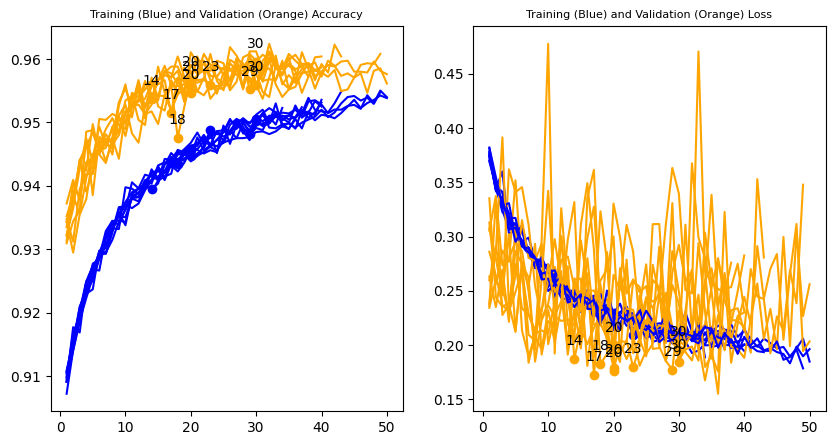

Group of Lambda-Value: 1000


<Figure size 2000x1000 with 0 Axes>

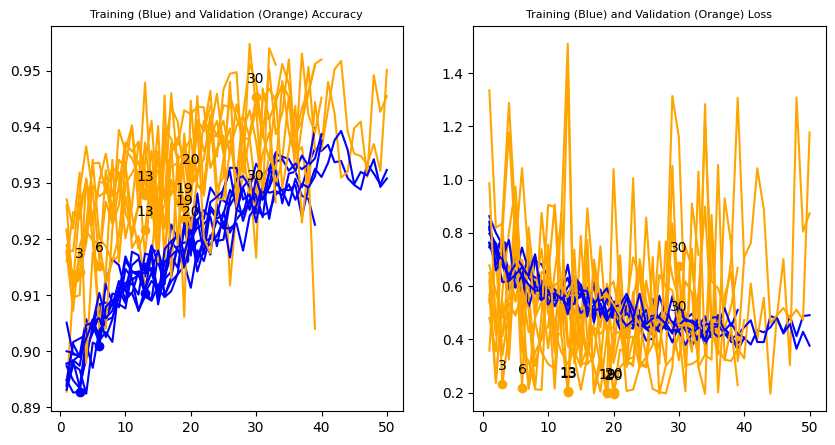

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import time
nb_epoch = 50
patience = 20
df.groupby("cost")

for x, group in df.groupby("cost"):
  fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
  fig, ax = plt.subplots(1,2)
  print("Group of Lambda-Value:",   x)

  # group
  for item in group.model_history:
    plot_model_history_all(item)    
  plt.show()
    # for item, cm3 in zip(group.model_history, group.cm):

  #   # cm3_wodiag = cm3*(np.ones((10,10)) - np.eye(10))

  #   # ax[2] = sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r, cbar=False) # font size
  #   # ax[2].set_xlabel('Predicted Class')
  #   # ax[2].set_ylabel('True Class')
  #   # ax[2].set_title('# of misclassifications of 9 as 4 is '+str(cm3[4][9]))
  #   # cbar = ax[2].collections[0].colorbar
  #   # cbar.remove() # Just takes up valuable room and is worthless
  #   plot_model_history_all(item)    

  #   #   ax[0].set_title("Lambda Value of"+str(df["cost"]))
    
  # #   # print(0+r,' to ', r+4+1)  #Correct

In [22]:
# plot_model_history(model_history, nb_epoch, cm3)
# # plot_model_history(model2_history, nb_epoch, cm3)
# # plt.gcf().set_size_inches(15, 5)  # this works 
# plt.gcf().suptitle(f"Lambda Value {lambda_val} for {nb_epoch} Epochs and Patience {patience} " )
# # print("The {0} runs {1} miles in {2} minutes".format("dog", 5, 10))

In [23]:
# for i in (model_history_all):
#   plot_model_history(i, nb_epoch, cm3) # This doesn't work ecause its all on separate figures and
# it only takes a static number of epochs and cm


In [25]:
# cm3_wodiag = cm3*(np.ones((10,10)) - np.eye(10))

# ax = sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r) # font size
# ax.set_xlabel('Predicted Class')
# ax.set_ylabel('True Class')
# ax.set_title('# of misclassifications of 9 as 4 is '+str(cm3[4][9]))

# fig = plt.gcf()
# fig.suptitle('Misclassification Matrix for Validation Set with Lambda Value of '+str(lambda_val)+"-After "+str(nb_epoch)+" epochs and patience of "+str(patience), fontsize=16)

# # cm3[4][9]


In [26]:
# plot_3_fx(model_history, model_history2, model_history2, 5, 9 , 9)
 

In [27]:
def combine(*args): 
    combined_string = ""
    for arg in args:
        combined_string += str(arg)
    return combined_string

#example
combine("Hello", "World") #returns "HelloWorld"

'HelloWorld'

In [29]:
# plt.plot(range(1, len(model_history.history['loss'] + model2_history.history['loss'])+1),model_history.history['loss'] + model2_history.history['loss'], label='train')
# plt.plot(range(1, len(model_history.history['val_loss'] + model2_history.history['val_loss'])+1),model_history.history['val_loss'] + model2_history.history['val_loss'] , label='valid')
# plt.legend()

#### Plot all three phases together

In [30]:
# def plot_3_fx(model1_history, model2_history, model3_history, restored_weights1, restored_weights2, restored_weights3):
  
#   tot_epochs = restored_weights1 + restored_weights2 + restored_weights3

#   #Label is the epoch weights are restored 
#   label1 = f"{restored_weights1}"
#   #Label_vale is the value at which the epoch weights are restored 
#   label_value1 = f"{ model1_history.history['val_categorical_accuracy'][restored_weights1-1]}"
#   # print("Label1: ", label1, "Val_Cat_Acc Value1: ", label_value1)


#   #Label is the epoch weights are restored in the second phase of training
#   # if restoredweights are 5 then it'll be after the max number of epochs of the first models training 
#   label2 = f"{restored_weights2}"
#   #Label_vale is the value at which the epoch weights are restored 
#   label_value2 = f"{ model2_history.history['val_categorical_accuracy'][restored_weights2-1]}"
#   # print("Label2: ", label2, "Val_Cat_Acc Value2: ", label_value2)

#   #Label is the epoch weights are restored in the second phase of training
#   # if restoredweights are 5 then it'll be after the max number of epochs of the first models training 
#   label3 = f"{restored_weights3}"
#   #Label_vale is the value at which the epoch weights are restored 
#   label_value3 = f"{ model3_history.history['val_categorical_accuracy'][restored_weights3-1]}"
#   # print("Label3: ", label3, "Val_Cat_Acc Value3: ", label_value3)

 
  
#   epochs = [restored_weights1, restored_weights2, restored_weights3]
#   models = [model1_history, model2_history, model3_history]

#   grab_n_epochs_of_model_metric_fun = lambda epoch, model, metric: model.history[metric][:epoch]

#   model_total_cat_acc =     np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['categorical_accuracy']*3)), axis=0)
#   model_total_val_cat_acc = np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['val_categorical_accuracy']*3)), axis=0)
  
#   model_total_loss =        np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['loss']*3)), axis=0)
#   model_total_val_loss =    np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['val_loss']*3)), axis=0)

#   model_total_val_9T_4P =   np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['9T_4P']*3)), axis=0)
#   model_total_val_4T_9P =   np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['4T_9P']*3)), axis=0)

  
#   #ScatterPlotPoint and Annotate RestoredWeights1 
#   offsets = [0,restored_weights1, restored_weights1+restored_weights2]
#   labels = [label1, label2, label3]

#   for metric in list(('val_categorical_accuracy', 'val_loss', '9T_4P')):


#     if(metric=='val_categorical_accuracy'):
#       plt.plot(range(1,tot_epochs+1), model_total_cat_acc)
#       plt.plot(range(1,tot_epochs+1), model_total_val_cat_acc)
#     elif(metric=='val_loss'):
#       plt.plot(range(1,tot_epochs+1), model_total_loss)
#       plt.plot(range(1,tot_epochs+1), model_total_val_loss)
#     else:
#       plt.plot(range(1,tot_epochs+1), model_total_val_9T_4P, color='orange')
#       plt.plot(range(1,tot_epochs+1), model_total_val_4T_9P, color='orange', linestyle='dashed')

#     plt.xlim(xmin=0)


#     for epoch, model, offset, label in zip(epochs, models, offsets, labels):
#       # print(f'Epoch of Restored-Weights: {epoch}, Model: {model}, Offset: {offset}')
#       plt.scatter((epoch+offset), model.history[metric][epoch-1] , color='orange')
#       plt.annotate(text=label,  xy=((epoch+offset), model.history[metric][epoch-1]),
#                   textcoords="offset points", 
#                   xytext=(0,10), 
#                   ha='center')
    
#     if(metric=='val_categorical_accuracy'):
#       plt.ylabel('accuracy')
#       plt.title('model accuracy')
#       plt.legend(['train', 'val'], loc='lower right')
    

#     elif(metric=='val_loss'):
#       plt.ylabel('loss')
#       plt.title('model loss')
#       plt.legend(['train', 'val'], loc='upper right')

#     else:
#       plt.ylabel('count')
#       plt.title('Validation misclassifications of 9T as 4P and reverse')
#       plt.legend(['9t_4p', '4t_9p'], loc='upper right')
    

#     plt.xlabel('epoch (starts at 1)') 
    
#     plt.show()


#   history =   {'categorical_accuracy': model_total_cat_acc , 
#               'val_categorical_accuracy': model_total_val_cat_acc  , 
#             'loss': model_total_loss,
#               'val_loss': model_total_val_loss ,   
#               '9T_4P': model_total_val_9T_4P ,  
#               '4T_9P': model_total_val_4T_9P}
 


#   return history
 


In [31]:
def plot_2_fx(model1_history, model2_history, restored_weights1, restored_weights2):
  
  tot_epochs = restored_weights1 + restored_weights2  

  #Label is the epoch weights are restored 
  label1 = f"{restored_weights1}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value1 = f"{ model1_history.history['val_categorical_accuracy'][restored_weights1-1]}"
  # print("Label1: ", label1, "Val_Cat_Acc Value1: ", label_value1)


  #Label is the epoch weights are restored in the second phase of training
  # if restoredweights are 5 then it'll be after the max number of epochs of the first models training 
  label2 = f"{restored_weights2}"
  #Label_vale is the value at which the epoch weights are restored 
  label_value2 = f"{ model2_history.history['val_categorical_accuracy'][restored_weights2-1]}"
  # print("Label2: ", label2, "Val_Cat_Acc Value2: ", label_value2)

  # #Label is the epoch weights are restored in the second phase of training
  # # if restoredweights are 5 then it'll be after the max number of epochs of the first models training 
  # label3 = f"{restored_weights3}"
  # #Label_vale is the value at which the epoch weights are restored 
  # label_value3 = f"{ model3_history.history['val_categorical_accuracy'][restored_weights3-1]}"
  # # print("Label3: ", label3, "Val_Cat_Acc Value3: ", label_value3)

 
  
  epochs = [restored_weights1, restored_weights2, ]
  models = [model1_history, model2_history, ]

  grab_n_epochs_of_model_metric_fun = lambda epoch, model, metric: model.history[metric][:epoch]

  model_total_cat_acc =     np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['categorical_accuracy']*2)), axis=0)
  model_total_val_cat_acc = np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['val_categorical_accuracy']*2)), axis=0)
  
  model_total_loss =        np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['loss']*2)), axis=0)
  model_total_val_loss =    np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['val_loss']*2)), axis=0)

  model_total_val_9T_4P =   np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['9T_4P']*2)), axis=0)
  model_total_val_4T_9P =   np.concatenate(list(map(grab_n_epochs_of_model_metric_fun, epochs, models, ['4T_9P']*2)), axis=0)

  # print("model_total_val_9T_4P: ", model_total_val_9T_4P)

  
  #ScatterPlotPoint and Annotate RestoredWeights1 
  offsets = [0,restored_weights1, ]
  labels = [label1, label2, ]

  for metric in list(('val_categorical_accuracy', 'val_loss', '9T_4P')):


    if(metric=='val_categorical_accuracy'):
      ax[0].plot(range(1,tot_epochs+1), model_total_cat_acc ,alpha=0.5)
      ax[0].plot(range(1,tot_epochs+1), model_total_val_cat_acc, alpha=0.5)
    elif(metric=='val_loss'):
      ax[1].plot(range(1,tot_epochs+1), model_total_loss, alpha=0.5)
      ax[1].plot(range(1,tot_epochs+1), model_total_val_loss, alpha=0.5)
    else:
      ax[2].plot(range(1,tot_epochs+1), model_total_val_9T_4P, color='green', alpha=0.5)
      ax[2].plot(range(1,tot_epochs+1), model_total_val_4T_9P, color='orange', linestyle='dashed', alpha=0.5)


    axes = [0, 1, 2]

    # for a, epoch, model, offset, label in zip(axes, epochs, models, offsets, labels):
    #   # print(f'Epoch of Restored-Weights: {epoch}, Model: {model}, Offset: {offset}')
    #   ax[a].scatter((epoch+offset), model.history[metric][epoch-1] , color='orange')
    #   ax[a].annotate(text=label,  xy=((epoch+offset), model.history[metric][epoch-1]),
    #               textcoords="offset points", 
    #               xytext=(0,10), 
    #               ha='center')
    
    if(metric=='val_categorical_accuracy'):
      ax[0].set_ylabel('accuracy')
      ax[0].set_title('Accuracy')
      ax[0].legend(['train', 'val'], loc='lower right')
    

    elif(metric=='val_loss'):
      ax[1].set_ylabel('loss')
      ax[1].set_title('Loss')
      ax[1].legend(['train', 'val'], loc='upper right')

    else:
      ax[2].set_ylabel('count')
      ax[2].set_title('Val Misclasses')
      ax[2].legend(['9t_4p', '4t_9p'], loc='upper right')
    

    plt.xlabel('epoch (starts at 1)') 
    # plt.xlim(xmin=0)


  history =   {'categorical_accuracy': model_total_cat_acc , 
              'val_categorical_accuracy': model_total_val_cat_acc  , 
            'loss': model_total_loss,
              'val_loss': model_total_val_loss ,   
              '9T_4P': model_total_val_9T_4P ,  
              '4T_9P': model_total_val_4T_9P}
 


  return history
 


Group of Lambda-Value: 1


<Figure size 2000x1000 with 0 Axes>

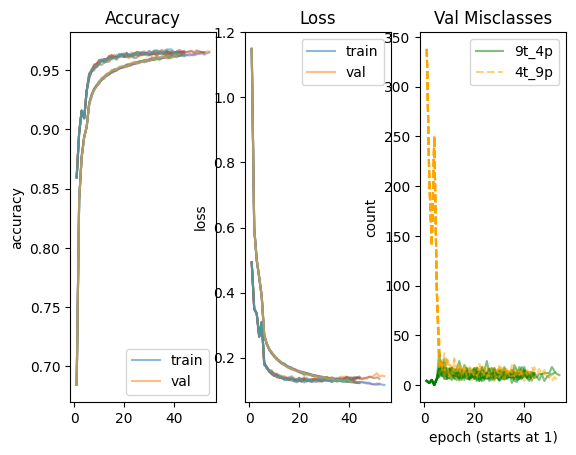

Group of Lambda-Value: 10


<Figure size 2000x1000 with 0 Axes>

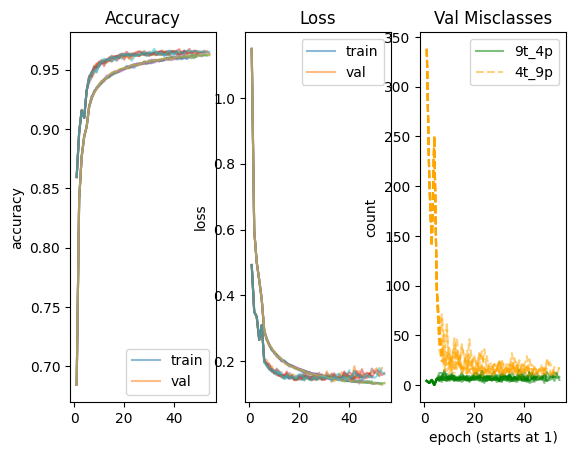

Group of Lambda-Value: 100


<Figure size 2000x1000 with 0 Axes>

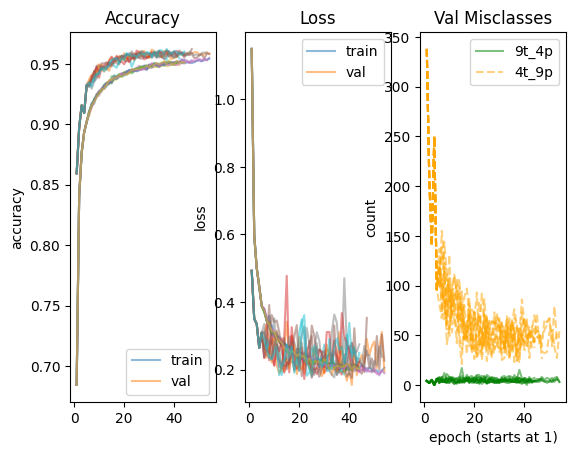

Group of Lambda-Value: 1000


<Figure size 2000x1000 with 0 Axes>

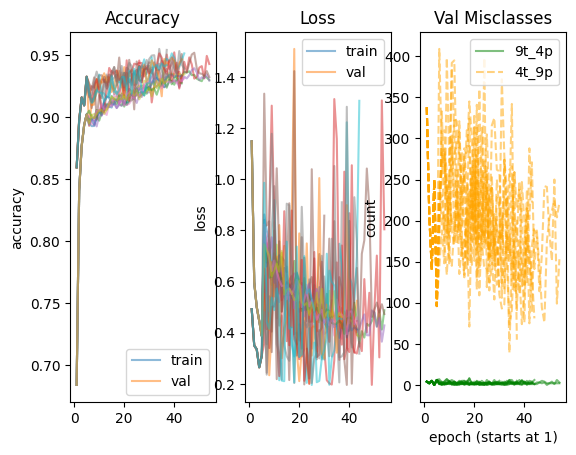

In [32]:
for x, group in df.groupby("cost"):
  fig = plt.figure(figsize=(20, 10)) # I don't think this works for some reason
  fig, ax = plt.subplots(1,3)
  print("Group of Lambda-Value:",   x)
  for item in group.model_history:
    plot_2_fx(model_history, item, 5, max(item.epoch) )
  plt.show()


In [33]:
for x, group in df.groupby("cost"):
  print(x)
  print(sum(group.cm)/10)

1
       0      1      2      3      4      5      6      7      8      9
0  706.0    0.0    1.6    0.4    0.1    2.9    4.4    1.6    0.8    1.2
1    0.0  835.3    4.8    1.8    0.0    1.9    1.6    0.9    2.7    0.0
2    4.4    0.9  757.9    5.1    2.5    0.0    3.0    6.9    3.2    0.1
3    1.3    0.1    7.4  724.9    0.4    7.7    0.1    7.8    5.3    0.0
4    0.6    0.0    4.4    0.0  724.1    0.1    4.7    0.8    2.5   11.8
5    3.5    0.3    0.8    6.7    1.5  647.1    4.5    2.4    5.8    3.4
6    5.8    2.6    1.3    0.0    4.2    3.4  684.3    0.3    4.1    0.0
7    0.1    7.7    8.5    4.6    3.0    0.2    1.0  729.8    0.3    6.8
8    5.4    2.4    4.4    5.0    4.1    4.4    3.2    4.5  694.0    3.6
9    3.3    3.5    0.2    7.1    9.8   10.2    0.2    5.2    3.6  725.9
10
       0      1      2      3      4      5      6      7      8      9
0  705.7    0.0    1.5    1.1    0.0    3.5    3.9    1.5    0.8    1.0
1    0.0  835.9    5.0    1.8    0.0    1.7    1.1    1.0  

1


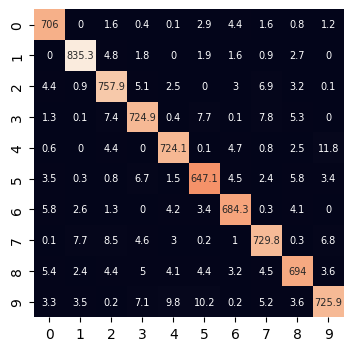

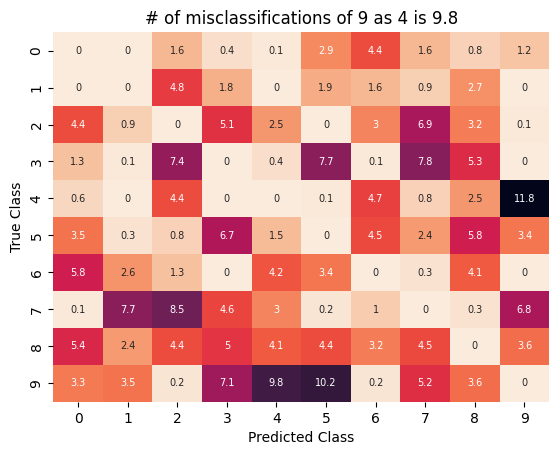

10


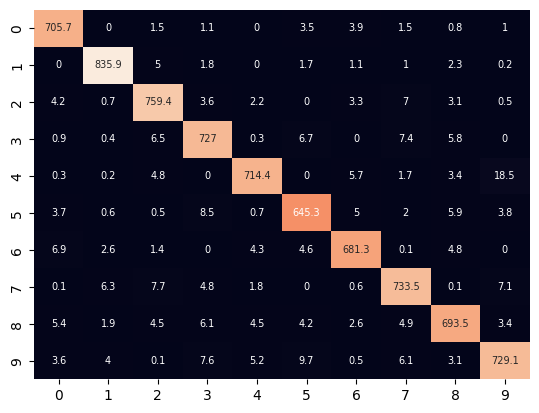

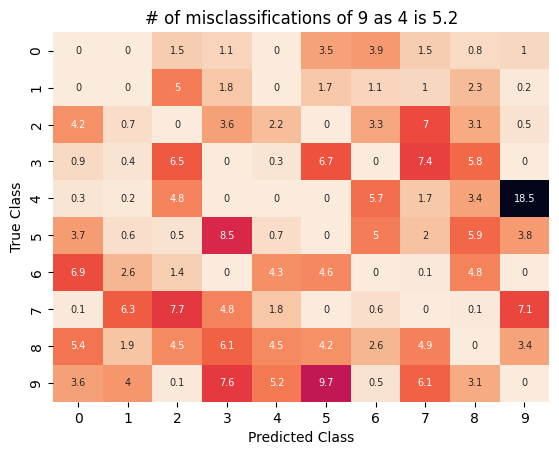

100


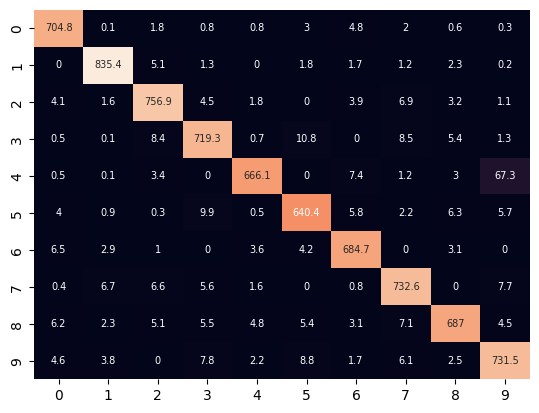

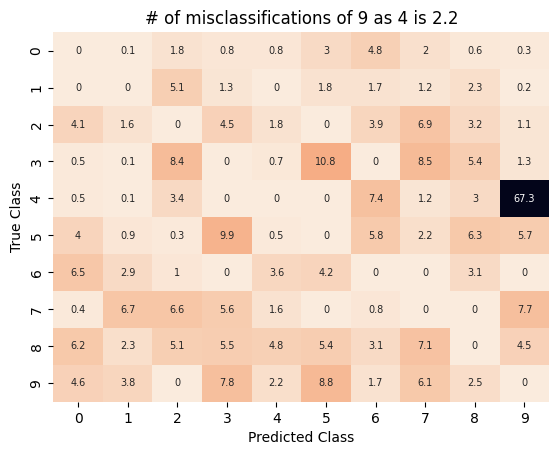

1000


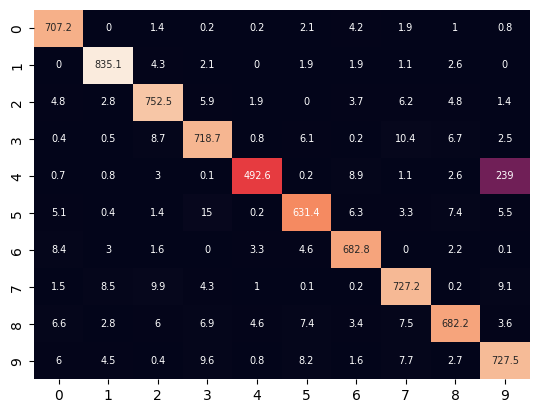

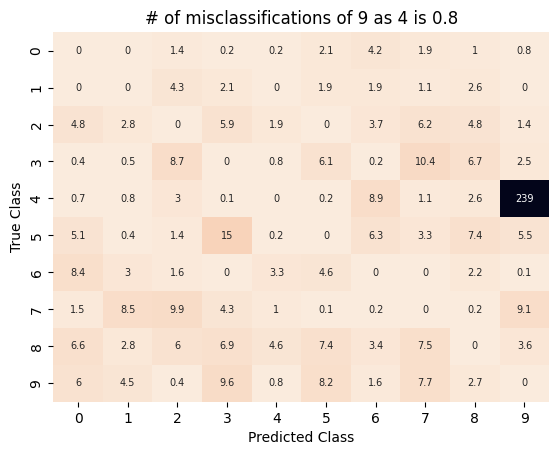

In [34]:
plt.figure(figsize = (4,4))
for x, group in df.groupby("cost"):
  print(x)
  cm3 = (sum(group.cm)/10)
  sns.heatmap(cm3, annot=True, annot_kws={"size": 7},  fmt='g', cbar=False) # font size
  plt.show()
  # cm_using_weighted_new = cm3
 

  cm3_wodiag = cm3*(np.ones((10,10)) - np.eye(10))
  sns.heatmap(cm3_wodiag, annot=True, annot_kws={"size": 7},  fmt='g', cmap=sns.cm.rocket_r, cbar=False) # font size
  plt.xlabel('Predicted Class')
  plt.ylabel('True Class')
  plt.title('# of misclassifications of 9 as 4 is '+str(cm3[4][9]))
  plt.show()
  # cbar.remove() # Just takes up valuable room and is worthless
